In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import *
from tensorflow.keras.activations import gelu
from tensorflow.keras.utils import plot_model
from utils.plot_utils import plot_iou_trainId, plot_iou_catId, label_to_rgb, display
from utils.data_utils import get_labels, parse_record, get_dataset_from_tfrecord
from data_loaders import CityscapesLoader
from setr import ClassToken, AddPositionEmbs, MultiHeadSelfAttention, TransformerBlock

K.clear_session()
# physical_devices = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
# print(physical_devices,"\n")
# enable_amp() 

Tensorflow version:  2.5.0


In [2]:
n_classes = 20
img_size = 768
patch_size = 16

BATCH_SIZE = 6
BUFFER_SIZE = 512

labels = get_labels()
trainid2label = { label.trainId : label for label in labels }
catid2label = { label.categoryId : label for label in labels }

In [3]:
pipeline = CityscapesLoader(
    img_height=img_size, 
    img_width=img_size, 
    n_classes=n_classes
)

In [4]:
dataset, info = tfds.load(
    name = 'cityscapes/semantic_segmentation', 
    # data_dir = '/workspace/tensorflow_datasets/', 
    with_info = True,
    shuffle_files=True
)

In [5]:
train = dataset['train'].map(pipeline.load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
valid = dataset['validation'].map(pipeline.load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

TRAIN_LENGTH = info.splits['train'].num_examples
VALID_LENGTH = info.splits['validation'].num_examples

train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


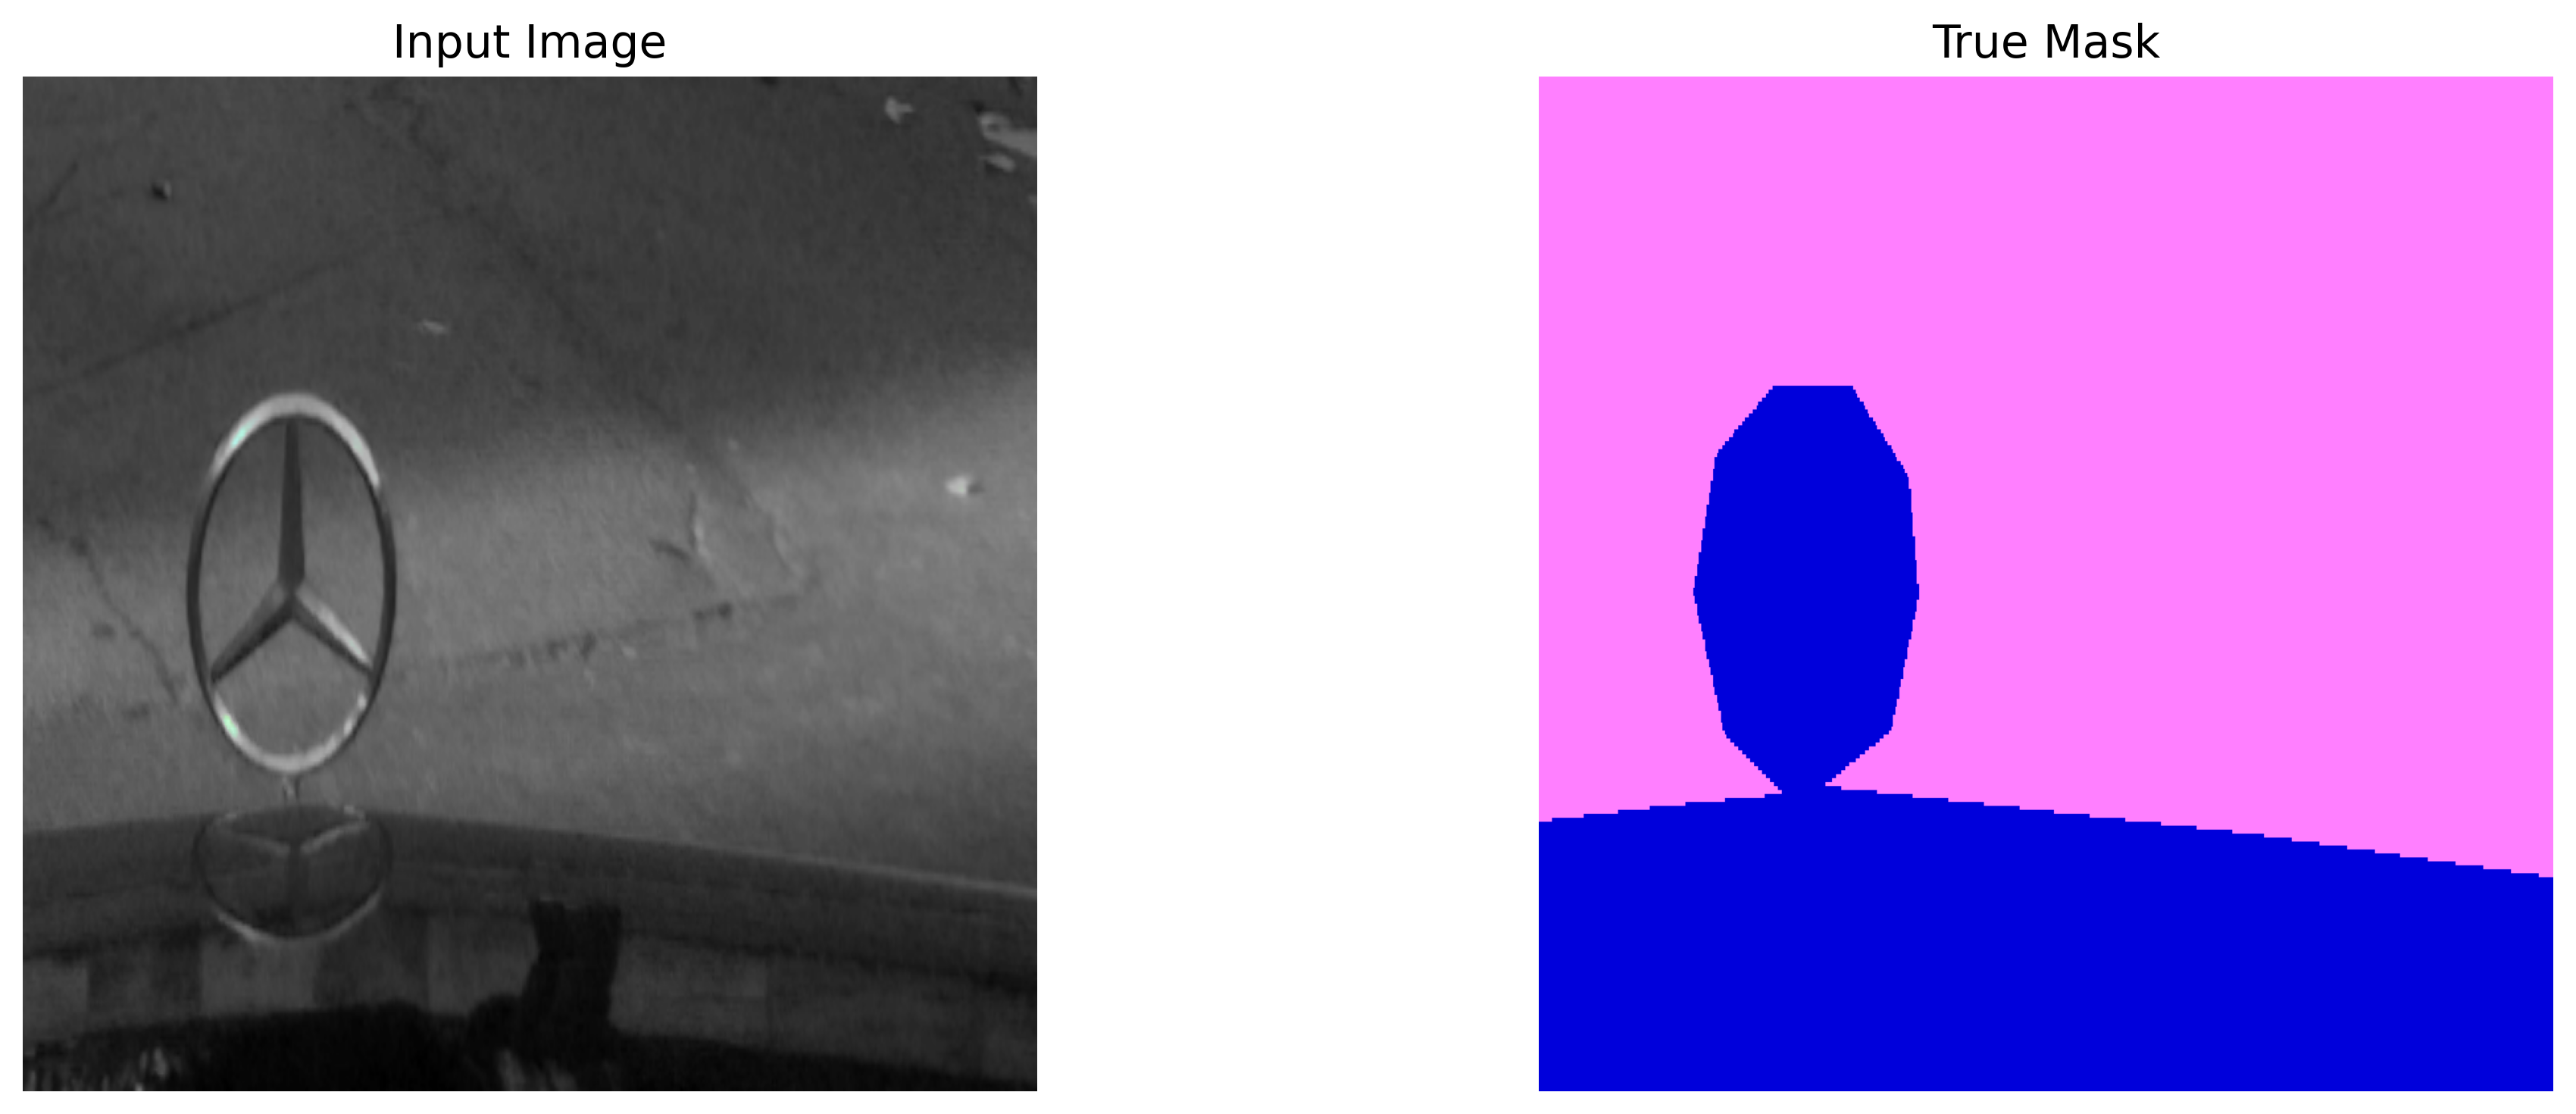

In [6]:
for image, mask in train.take(3): 
    sample_image, sample_mask = image, mask

sample_mask = sample_mask[..., tf.newaxis]
sample_mask = label_to_rgb(sample_mask.numpy())
display([sample_image, sample_mask])

In [7]:
def SETR_PUP(image_size, patch_size, num_layers, num_classes, hidden_size, num_heads, name, mlp_dim, dropout=0.1):
    """Build a ViT model.

    Args:
        image_size: The size of input images.
        patch_size: The size of each patch (must fit evenly in image_size)
        num_layers: The number of transformer layers to use.
        hidden_size: The number of filters to use
        num_heads: The number of transformer heads
        mlp_dim: The number of dimensions for the MLP output in the transformers.
        dropout_rate: fraction of the units to drop for dense layers.
    """
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    
    x = Input(shape=(image_size, image_size, 3))
    y = Conv2D(filters=hidden_size, kernel_size=patch_size, strides=patch_size, padding="valid", name="embedding")(x)
    y = Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = ClassToken(name="class_token")(y)
    y = AddPositionEmbs(name="Transformer/posembed_input")(y)
    for n in range(num_layers):
        y, _ = TransformerBlock(
            num_heads=num_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
        )(y)
    y = LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)
    y = Lambda(lambda v: v[:, :-1], name="ExtractToken")(y)
    
    
    y = Reshape(target_shape=(int(image_size//16), int(image_size//16), hidden_size))(y)
    
    y = UpSampling2D(size=(2,2), interpolation='bilinear')(y)
    y = Conv2D(hidden_size, kernel_size=(3,3), strides=(1,1), padding='same')(y)

    y = UpSampling2D(size=(2,2), interpolation='bilinear')(y)
    y = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(y)

    y = UpSampling2D(size=(2,2), interpolation='bilinear')(y)
    y = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(y)

    y = UpSampling2D(size=(2,2), interpolation='bilinear')(y)
    y = Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same')(y)
    
    y = Conv2D(num_classes, kernel_size=(1,1), strides=(1,1), padding='same', dtype='float32')(y)
    
    return tf.keras.models.Model(inputs=x, outputs=y, name=name)

In [8]:
CONFIG_B = {
    "dropout": 0.1,
    "mlp_dim": 3072,
    "num_heads": 12,
    "num_layers": 12,
    "hidden_size": 768,
    "name": "SETR-B_16"
}

CONFIG_L = {
    "dropout": 0.1,
    "mlp_dim": 4096,
    "num_heads": 16,
    "num_layers": 24,
    "hidden_size": 1024,
    "name": "SETR-L_16"
}

config = CONFIG_L

In [ ]:
K.clear_session()

In [9]:
model = SETR_PUP(
    image_size = img_size,
    patch_size = patch_size,
    num_classes = n_classes,
    num_layers = config["num_layers"],
    hidden_size = config["hidden_size"],
    num_heads = config["num_heads"],
    name = config["name"],
    mlp_dim = config["mlp_dim"],
    dropout = 0.1,
)

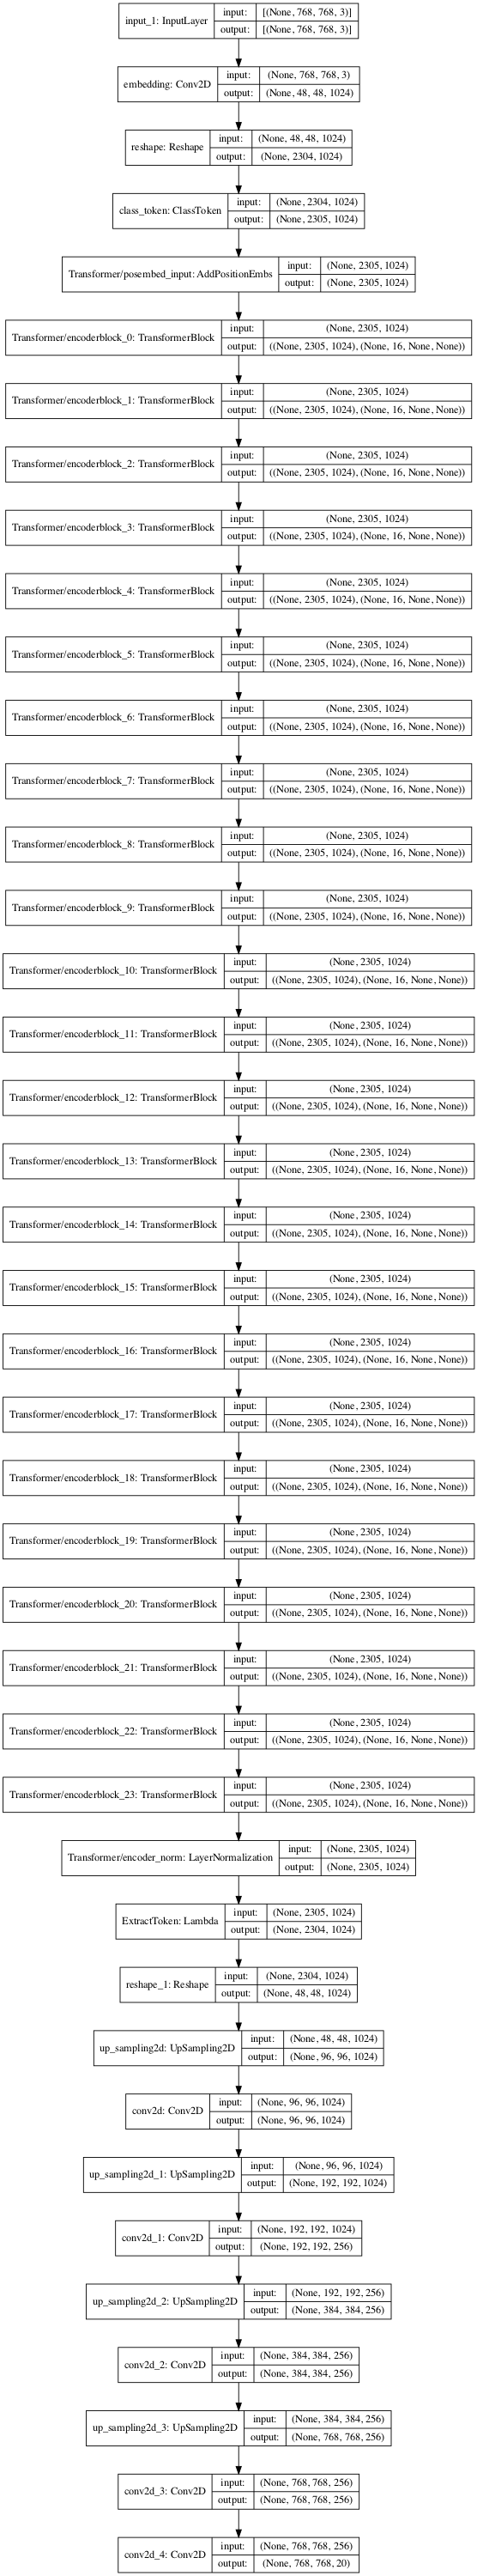

In [10]:
plot_model(model, show_shapes=True, dpi=64, expand_nested=True)

In [12]:
model.load_weights("weights/vit_l16_imagenet21k.h5", by_name=True)